In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [25]:
data = pd.read_csv('all_perth_310121.csv')

In [26]:
data1 = data.drop(['ADDRESS','CBD_DIST','NEAREST_STN','NEAREST_STN_DIST','DATE_SOLD','POSTCODE','LATITUDE','LONGITUDE','NEAREST_SCH','NEAREST_SCH_DIST','NEAREST_SCH_RANK'],axis='columns')

In [27]:
data2 = data1.dropna()
data2.isnull().sum()

SUBURB        0
PRICE         0
BEDROOMS      0
BATHROOMS     0
GARAGE        0
LAND_AREA     0
FLOOR_AREA    0
BUILD_YEAR    0
dtype: int64

In [28]:
data3 = data2[data2.BATHROOMS<data2.BEDROOMS+2]
data3.shape

(28252, 8)

In [45]:
data9 = data3[data3.FLOOR_AREA>data3.LAND_AREA]
data9.shape

(0, 8)

In [29]:
data3.SUBURB = data3.SUBURB.apply(lambda x: x.strip())
location_stats = data3['SUBURB'].value_counts(ascending=False)
location_stats

Bertram          204
Henley Brook     198
Jane Brook       195
Merriwa          193
Mindarie         192
                ... 
Neerabup           6
Hope Valley        3
Munster            1
Kwinana Beach      1
Wangara            1
Name: SUBURB, Length: 317, dtype: int64

In [30]:
location_stats_less_than_5 = location_stats[location_stats<=5]
data3.SUBURB = data3.SUBURB.apply(lambda x: 'other' if x in location_stats_less_than_5 else x)
len(data3.SUBURB.unique())

314

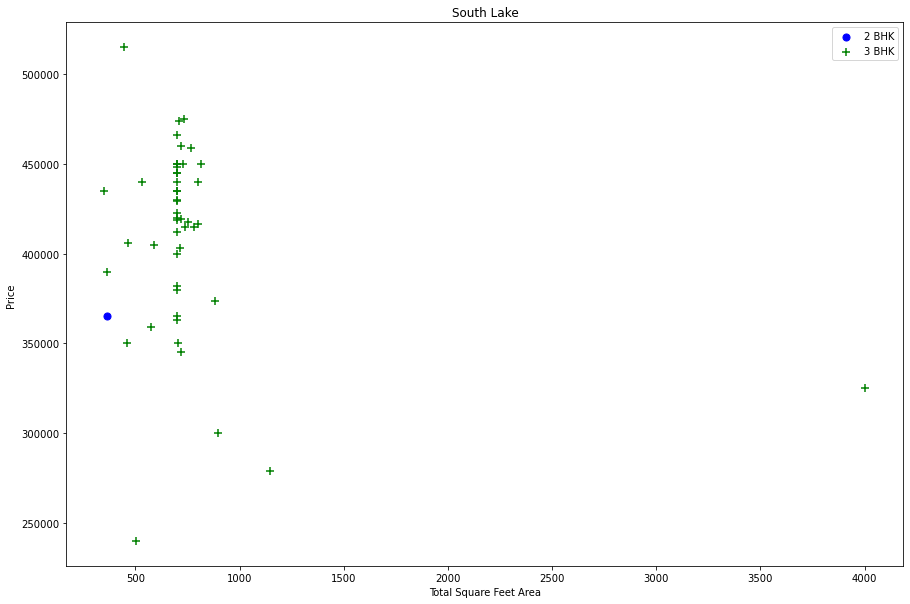

In [31]:
def plot_scatter_chart(df,SUBURB):
    bhk2 = df[(df.SUBURB==SUBURB) & (df.BEDROOMS==2)]
    bhk3 = df[(df.SUBURB==SUBURB) & (df.BEDROOMS==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.LAND_AREA,bhk2.PRICE,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.LAND_AREA,bhk3.PRICE,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price ")
    plt.title(SUBURB)
    plt.legend()
    
plot_scatter_chart(data3,"South Lake")

In [32]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('SUBURB'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BEDROOMS'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.PRICE),
                'std': np.std(bhk_df.PRICE),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BEDROOMS'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.PRICE<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
data4 = remove_bhk_outliers(data3)
data4.shape

(24036, 8)

In [33]:
dummies = pd.get_dummies(data4.SUBURB)
data5 = pd.concat([data4,dummies.drop('other',axis='columns')],axis='columns')
data5.head(3)

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,Alexander Heights,Alfred Cove,...,Wilson,Winthrop,Woodbridge,Woodlands,Woodvale,Wooroloo,Wungong,Yanchep,Yangebup,Yokine
0,South Lake,565000,4,2,2.0,600,160,2003.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wandi,365000,3,2,2.0,351,139,2013.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Camillo,287000,3,1,1.0,719,86,1979.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data6 = data5.drop('SUBURB',axis='columns')
data6.shape

(24036, 320)

In [35]:
X = data6.drop(['PRICE'],axis='columns')
y = data6.PRICE
y.head(3)

0    565000
1    365000
2    287000
Name: PRICE, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=9)

In [37]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8239537165275148

In [38]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.81635466, 0.81640139, 0.82006483, 0.80968009, 0.80942069])

In [39]:
from sklearn.tree import DecisionTreeRegressor
Dtr =DecisionTreeRegressor()
Dtr.fit(X_train,y_train)
Dtr.score(X_test,y_test)

0.5323721178909812

In [40]:
from sklearn.ensemble import RandomForestRegressor
rdm = RandomForestRegressor()
rdm.fit(X_train,y_train)
rdm.score(X_test,y_test)

0.735315694265136

In [42]:
X.head(3)

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,Alexander Heights,Alfred Cove,Alkimos,Anketell,...,Wilson,Winthrop,Woodbridge,Woodlands,Woodvale,Wooroloo,Wungong,Yanchep,Yangebup,Yokine
0,4,2,2.0,600,160,2003.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2,2.0,351,139,2013.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1.0,719,86,1979.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
def predict_price(location,lArea,fArea,bhk,bath,garage,year):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bhk
    x[1] = bath
    x[2] = garage
    x[3] = lArea
    x[4] = fArea
    x[5] = year
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [49]:
predict_price('South Lake',1000,500, 4, 2 ,2 ,2003)

1043831.5913891704

In [50]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [51]:
import pickle
with open('mini_projet.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [52]:
data6.BUILD_YEAR.unique()

array([2003., 2013., 1979., 1953., 2014., 1983., 1999., 1977., 2008.,
       2002., 2004., 1985., 1959., 2000., 1972., 2007., 1920., 1981.,
       2006., 2012., 1996., 1988., 1974., 1998., 1989., 1978., 2005.,
       1991., 2011., 1994., 1960., 2015., 2001., 1945., 2010., 1950.,
       1995., 2016., 1965., 1992., 1970., 1975., 1984., 1993., 1958.,
       1980., 1990., 1986., 1962., 1900., 2009., 1969., 1982., 1997.,
       1935., 1955., 1930., 1966., 1976., 1951., 1964., 1987., 1923.,
       1973., 1971., 1961., 1968., 1967., 1928., 1956., 1949., 1946.,
       1957., 1952., 1910., 1963., 1927., 1947., 1936., 1940., 1954.,
       1937., 1917., 1915., 1924., 1938., 1939., 1912., 1925., 1922.,
       1919., 1934., 1948., 1905., 1942., 1921., 1890., 1913., 1918.,
       1904., 1870., 1903., 1908., 1929., 1914., 1932., 1926., 1941.,
       1933., 1931., 2017., 1894., 1916., 1868., 1886., 1880., 1907.,
       1902., 1897., 1943., 1895., 1892., 1901.])